In [1]:
import yfinance as yh
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
from datetime import datetime, timedelta
import numpy as np
import utils as ut
from sklearn.ensemble import RandomForestClassifier
import warnings
from pycaret.classification import *
warnings.filterwarnings("ignore")

In [2]:
symbol_train = [
    'NVDA', "AAPL", "MSFT", "GOOG", "AMZN", "META", "TSLA",
    "CRM", "AMD", "BABA", "INTC", "PYPL", "TTD", "EA", 
    "ZG", "MTCH", "YELP", "ADBE", "ORCL", "SAP", "CSCO", "UBER", "LYFT", "ZM",
    "NFLX", "SNAP", "SHOP", "TWLO", "SQ", "SPOT", "NET", "ROKU",
    "DOCU", "PANW", "CRWD", "SNOW", "ASML"
]

In [3]:
var = ['signal_bollinger_12_1', 'signal_bollinger_12_2', 'signal_bollinger_20_1',
        'signal_bollinger_20_2', 'RSI_14_30_70', 'signal_rsi_14_30_70', 'RSI_14_20_80',
        'signal_rsi_14_20_80', 'RSI_8_30_70', 'signal_rsi_8_30_70', 'RSI_8_20_80',
        'signal_rsi_8_20_80', 'Stochastic_K_14_3', 'Stochastic_D_14_3', 'Stochastic_K_14_5',
        'Stochastic_D_14_5', 'Stochastic_K_8_3', 'Stochastic_D_8_3', 'Stochastic_K_8_5', 
        'Stochastic_D_8_5', 'signal_atr_14_1', 'signal_atr_14_1.5', 'signal_atr_8_1', 
        'signal_atr_8_1.5', 'signal_atr_30_1', 'signal_atr_30_1.5', 'OBV_trend',
        'signal_obv_1', 'signal_obv_3', 'signal_obv_4', 'Williams_R_14',
        'Williams_R_8', 'Williams_R_30', 'adx_14', 'adx_8', 'adx_30',
        'Aroon_Oscillator_14', 'Aroon_Oscillator_8', 'Aroon_Oscillator_30',
        'Keltner_20_1.5', 'Keltner_20_2', 'Keltner_20_2.5', 'Keltner_14_1.5',
        'Keltner_14_2', 'Keltner_14_2.5', 'Keltner_8_1.5', 'Keltner_8_2',
        'Keltner_8_2.5', 'CMF_20', 'CMF_14','CMF_8']

In [4]:
data = pl.read_csv('stocks_data.csv')
data = data.with_columns(
    pl.col("Date")
    .str.strptime(pl.Datetime, "%+").dt.replace_time_zone(None)
    .alias("Date"),

    pl.when(pl.col('daily_return').shift(-1)>0.016798).then(2).when(pl.col('daily_return').shift(-1)<-0.015432).then(1).otherwise(0).alias("target_5"),
    pl.when(pl.col('daily_return').shift(-1)>0).then(1).otherwise(0).alias("target_6")
)

In [5]:
data.filter(pl.col('period')=='train').select(pl.col('daily_return')).describe()

statistic,daily_return
str,f64
"""count""",35938.0
"""null_count""",0.0
"""mean""",0.000883
"""std""",0.034644
"""min""",-0.430797
"""25%""",-0.015432
"""50%""",0.000577
"""75%""",0.016798
"""max""",0.588163


In [6]:
data

Date,Open,High,Low,Close,Volume,Symbol,daily_return,target_1,target_2,target_3,target_4,period,signal_bollinger_12_1,signal_bollinger_12_2,signal_bollinger_20_1,signal_bollinger_20_2,RSI_14_30_70,signal_rsi_14_30_70,RSI_14_20_80,signal_rsi_14_20_80,RSI_8_30_70,signal_rsi_8_30_70,RSI_8_20_80,signal_rsi_8_20_80,Stochastic_K_14_3,Stochastic_D_14_3,Stochastic_K_14_5,Stochastic_D_14_5,Stochastic_K_8_3,Stochastic_D_8_3,Stochastic_K_8_5,Stochastic_D_8_5,signal_atr_14_1,signal_atr_14_1.5,signal_atr_8_1,signal_atr_8_1.5,signal_atr_30_1,signal_atr_30_1.5,OBV_trend,signal_obv_1,signal_obv_3,signal_obv_4,Williams_R_14,Williams_R_8,Williams_R_30,adx_14,adx_8,adx_30,Aroon_Oscillator_14,Aroon_Oscillator_8,Aroon_Oscillator_30,Keltner_20_1.5,Keltner_20_2,Keltner_20_2.5,Keltner_14_1.5,Keltner_14_2,Keltner_14_2.5,Keltner_8_1.5,Keltner_8_2,Keltner_8_2.5,CMF_20,CMF_14,CMF_8,target_5,target_6
datetime[μs],f64,f64,f64,f64,i64,str,f64,i64,i64,i64,i64,str,i64,i64,i64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32
2019-12-27 05:00:00,5.970384,5.983829,5.871043,5.897435,254644000,"""NVDA""",-0.009699,0,0,0,0,"""train""",0,0,1,0,89.838745,-1,89.838745,-1,82.810814,-1,82.810814,-1,84.018147,88.74717,84.018147,90.995121,69.674588,79.446957,69.674588,84.58539,0,0,0,0,0,0,-1,0,0,0,-15.981853,-30.325412,-11.920829,20.29193,46.405022,9.162862,-71.428571,-50.0,-46.666667,145.451567,121.588675,107.27094,131.204346,110.903259,98.722607,99.998791,87.499094,79.999275,0.014885,0.037688,0.029597,1,0
2019-12-30 05:00:00,5.875525,5.880754,5.752782,5.784152,258056000,"""NVDA""",-0.019209,1,0,0,0,"""train""",0,0,0,0,78.340418,-1,78.340418,0,60.456592,0,60.456592,0,68.936208,81.492693,68.936208,85.292105,23.836242,59.378388,23.836242,70.134542,0,0,-1,0,0,0,-1,-1,0,0,-31.063792,-76.163758,-22.900537,22.140035,42.714581,9.216388,-64.285714,-37.5,-46.666667,106.322373,92.24178,83.793424,92.653978,81.990484,75.592387,64.144529,60.608397,58.486717,-0.002047,0.02096,-0.083524,0,1
2019-12-31 05:00:00,5.748798,5.867807,5.729627,5.858346,231004000,"""NVDA""",0.012827,1,0,0,0,"""train""",0,0,0,0,79.030521,-1,79.030521,0,63.766032,0,63.766032,0,76.335909,76.430088,76.335909,82.302726,44.26376,45.924863,44.26376,61.288175,0,0,0,0,0,0,1,1,0,0,-23.664091,-55.73624,-15.70943,23.974636,37.420615,8.578801,-57.142857,62.5,-46.666667,121.755159,103.816369,93.053095,108.002522,93.501892,84.801513,80.337897,72.753423,68.202738,0.081698,0.057402,0.11538,2,1
2020-01-02 05:00:00,5.944242,5.973123,5.893701,5.973123,237536000,"""NVDA""",0.019592,0,0,0,0,"""train""",1,0,1,0,79.720874,-1,79.720874,0,61.300282,0,61.300282,0,92.689607,79.320575,92.689607,82.700719,83.733086,50.611029,83.733086,61.226402,0,0,1,0,0,0,1,1,0,0,-7.310393,-16.266914,-4.584879,25.956728,31.698401,8.550378,-50.0,62.5,-46.666667,146.08125,122.060938,107.64875,131.841197,111.380898,99.104718,103.71925,90.289437,82.23155,0.049881,0.065111,0.074208,1,0
2020-01-03 05:00:00,5.853366,5.921336,5.828468,5.877516,205384000,"""NVDA""",-0.016006,1,0,0,0,"""train""",0,0,0,0,67.103776,0,67.103776,0,41.59021,0,41.59021,0,71.285654,80.103723,71.285654,78.653105,50.856001,59.617615,50.856001,54.472735,0,0,0,0,0,0,-1,-1,0,0,-28.714346,-49.143999,-13.851386,26.368883,26.565178,8.454217,-42.857143,62.5,-46.666667,118.77225,101.579188,91.26335,103.728302,90.296226,82.236981,75.102519,68.826889,65.061511,0.069638,-0.007057,-0.00949,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-11-06 05:00:00,668.549988,673.039978,654.77002,661.429993,3208600,"""ASML""",-0.022219,1,0,0,0,"""test""",-1,0,0,0,35.960244,0,35.960244,0,19.551906,1,19.551906,1,9.513197,10.804007,9.513197,7.738724,10.887649,11.711884,10.887649,11.721144,0,0,0,0,0,0,-1,-1,0,0,-90.486803,-89.112351,-96.928862,29.099737,26.435717,13.062394,92.85714

In [7]:
from optbinning import MulticlassOptimalBinning
from optbinning import OptimalBinning

(CVXPY) Dec 05 06:46:18 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 05 06:46:18 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [8]:
X_train = data.filter(pl.col('period')=='train').select(var)
y_train = data.filter(pl.col('period')=='train').select("target_6")

X_validation = data.filter(pl.col('period')=='validation').select(var)
y_validation = data.filter(pl.col('period')=='validation').select("target_6")

X_test = data.filter(pl.col('period')=='test').select(var)
y_test = data.filter(pl.col('period')=='test').select("target_6")

variable = 'RSI_14_30_70'
x = X_train.to_pandas()[variable].values
y = y_train.to_pandas()['target_6'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(x, y)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 27.16)",2860,0.079582,1383,1477,0.516434,-0.028133,0.000063,7.870486e-06
1,"[27.16, 43.00)",8596,0.239190,4211,4385,0.510121,-0.002865,0.000002,2.453558e-07
2,"[43.00, 48.00)",3672,0.102176,1823,1849,0.503540,0.023463,0.000056,7.032406e-06
3,"[48.00, 52.10)",3018,0.083978,1554,1464,0.485089,0.097285,0.000795,9.932245e-05
4,"[52.10, inf)",17792,0.495075,8660,9132,0.513264,-0.015445,0.000118,1.476023e-05
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,35938,1.000000,17631,18307,0.509405,,0.001034,1.292309e-04


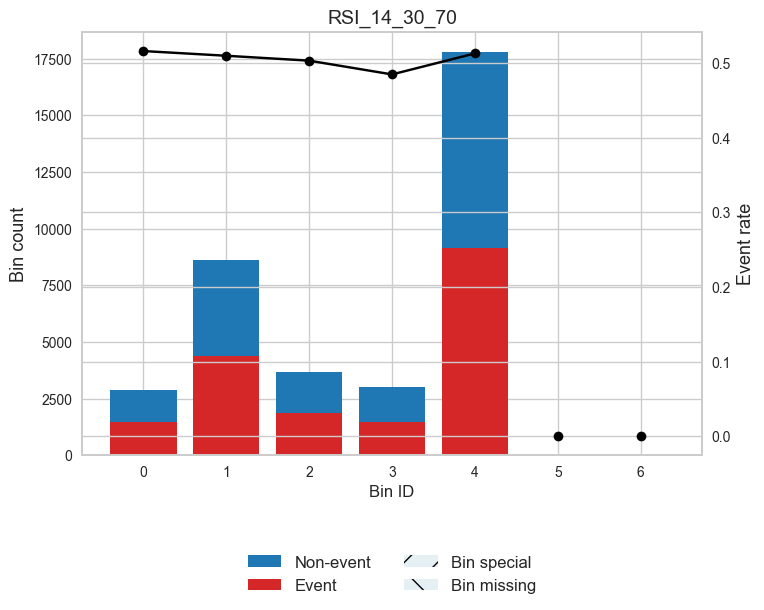

In [9]:
binning_table.plot(metric="event_rate")

In [10]:
iv_list = []
for i in var:
    variable = i
    x = X_train.to_pandas()[variable].values
    y = y_train.to_pandas()['target_6'].values

    optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
    optb.fit(x, y)
    binning_table = optb.binning_table
    iv_list.append(binning_table.build().IV['Totals'])

In [11]:
df_iv = pd.DataFrame({'variable': var, 'IV': iv_list})

In [12]:
df_iv.sort_values('IV').IV.describe()

count    51.000000
mean      0.001045
std       0.000716
min       0.000000
25%       0.000277
50%       0.001156
75%       0.001667
max       0.002153
Name: IV, dtype: float64

In [13]:
X_train = data.filter(pl.col('period')=='train').select(var)
y_train = data.filter(pl.col('period')=='train').select("target_5")

X_validation = data.filter(pl.col('period')=='validation').select(var)
y_validation = data.filter(pl.col('period')=='validation').select("target_5")

X_test = data.filter(pl.col('period')=='test').select(var)
y_test = data.filter(pl.col('period')=='test').select("target_5")

variable = 'RSI_14_30_70'
x = X_train.to_pandas()[variable].values
y = y_train.to_pandas()['target_5'].values

optb = MulticlassOptimalBinning(name=variable, solver="cp")
optb.fit(x, y)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Event_0,Event_1,Event_2,Event_rate_0,Event_rate_1,Event_rate_2
0,"(-inf, 38.52)",8415,0.234153,3653,2339,2423,0.434106,0.277956,0.287938
1,"[38.52, 43.42)",3339,0.092910,1580,878,881,0.473196,0.262953,0.263851
2,"[43.42, 57.94)",10699,0.297707,5327,2751,2621,0.497897,0.257127,0.244976
3,"[57.94, 70.37)",8024,0.223273,4301,1781,1942,0.536017,0.221959,0.242024
4,"[70.37, inf)",5461,0.151956,3083,1231,1147,0.564549,0.225417,0.210035
5,Special,0,0.000000,0,0,0,0.000000,0.000000,0.000000
6,Missing,0,0.000000,0,0,0,0.000000,0.000000,0.000000
Totals,,35938,1.000000,17944,8980,9014,0.499304,0.249875,0.250821


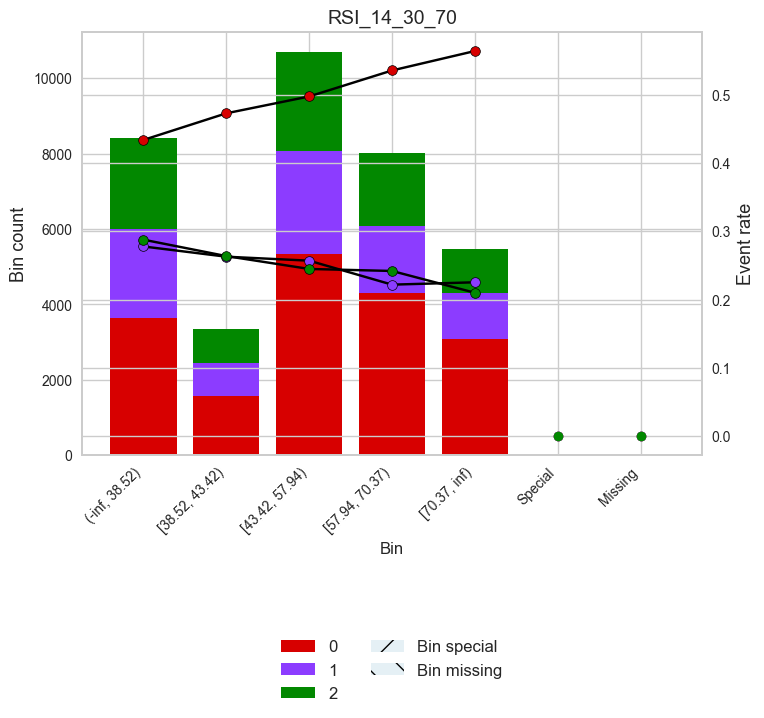

In [14]:
binning_table.plot(show_bin_labels=True)

In [15]:
df = data.filter(pl.col('Symbol')=='ASML').filter(pl.col('period')=='test')

In [16]:
symbol = "BTCB-USD"
info = yh.Ticker(symbol)
data = pl.DataFrame(info.history(period="1Y")[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index())
data = data.with_columns(pl.lit(symbol).alias("Symbol"))


In [17]:
df = ut.calculate_rsi(df, 14, 70, 30, True).to_pandas()

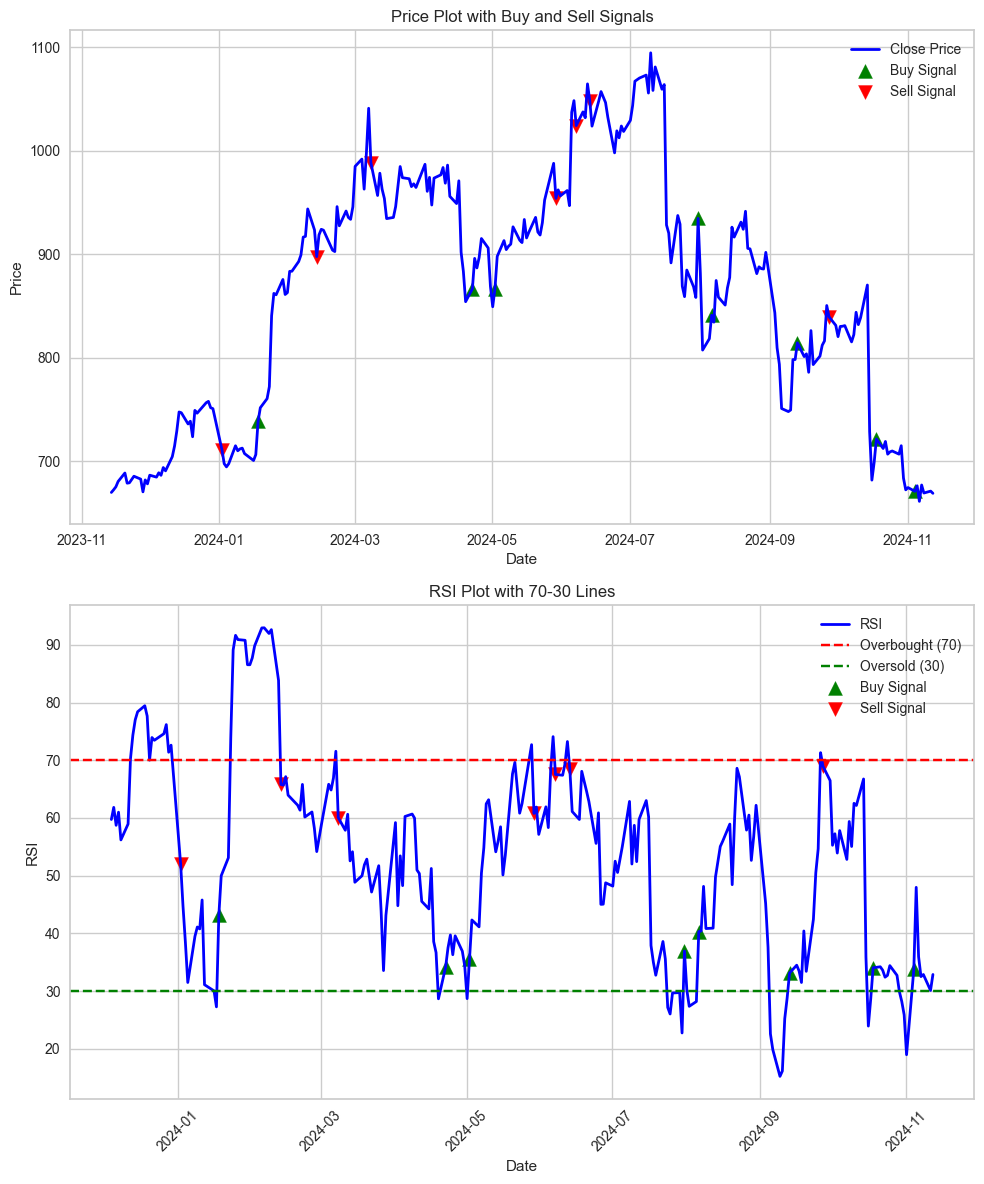

In [18]:

def generate_signals(rsi_series):
    signals = []
    
    for i in range(1, len(rsi_series)):
        if rsi_series[i-1] < 30 and rsi_series[i] > 30:
            signals.append('buy')
        elif rsi_series[i-1] > 70 and rsi_series[i] < 70:
            signals.append('sell')
        else:
            signals.append(None)
    
    signals.insert(0, None)
    
    return signals

df['Signal'] = generate_signals(df['RSI_14_30_70'])

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(df['Date'], df['Close'], label='Close Price', color='blue', lw=2)
buy_signals = df[df['Signal'] == 'buy']
sell_signals = df[df['Signal'] == 'sell']
axs[0].scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', s=100)
axs[0].scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', s=100)
axs[0].set_title('Price Plot with Buy and Sell Signals')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price')
axs[0].legend(loc='best')
axs[0].grid(True)

axs[1].plot(df['Date'], df['RSI_14_30_70'], label='RSI', color='blue', lw=2)
axs[1].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axs[1].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axs[1].scatter(buy_signals['Date'], buy_signals['RSI_14_30_70'], marker='^', color='green', label='Buy Signal', s=100)
axs[1].scatter(sell_signals['Date'], sell_signals['RSI_14_30_70'], marker='v', color='red', label='Sell Signal', s=100)
axs[1].set_title('RSI Plot with 70-30 Lines')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('RSI')
axs[1].legend(loc='best')
axs[1].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()  
